## Data Science in Python - Assignment 1
#### 19430456 - Christopher Kenny (Late Submission)
### Task 1 - Data Retrieval & Formatting

##### The API that I have decided to use is is the USGS.gov which is the U.S Geological Survey.The USGS monitors and collects data relating to seismic activity. <br>The aim of this project is to analyse various aspects of earthquakes in the last 10 years with a magnitude of 5.5 or higher.

In [295]:
import requests


usgs_api_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Parameters for the API request
params = {
    "format": "csv",   
    "starttime": "2013-01-01",  # Start date (Last 10 calendar years)
    "endtime": "2023-01-01",    # End date
    "limit": 10000,
    "minmagnitude": 5.5,      # Minimum earthquake magnitude
    "orderby": "magnitude"
}

# get request using asgs_api_url & chosen parameters
response = requests.get(usgs_api_url, params=params)

# checking if request is succesfful
if response.status_code == 200:
    # saving (writing) the csv response to a local csv file
    with open("earthquake_data_magnitude_5.csv", "w") as f:
        f.write(response.text)

    print("Earthquake data (magnitude >= 5.5) saved to earthquake_data_magnitude_5.csv")
else:
    print(f"Error: Failed to retrieve earthquake data. Status code: {response.status_code}")


Earthquake data (magnitude >= 5.5) saved to earthquake_data_magnitude_5.csv


### Task 2 - Loading & Preprocessing

In [296]:
import pandas as pd
#using pandas to convert the csv retrieved data to a pandas DataFrame
df = pd.read_csv("earthquake_data_magnitude_5.csv")
print(df.shape)
df.head()

(4593, 22)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2015-09-16T22:54:32.860Z,-31.5729,-71.6744,22.44,8.3,mww,NaN,19.0,0.684,1.02,...,2023-07-19T20:35:24.323Z,"48 km W of Illapel, Chile",earthquake,4.7,3.2,NaN,NaN,reviewed,us,us
1,2013-05-24T05:44:48.980Z,54.8920,153.2210,598.10,8.3,mww,385.0,10.0,NaN,1.02,...,2022-08-28T07:25:50.955Z,Sea of Okhotsk,earthquake,NaN,4.1,NaN,NaN,reviewed,us,us
2,2021-07-29T06:15:49.188Z,55.3635,-157.8876,35.00,8.2,mww,NaN,NaN,NaN,0.95,...,2023-07-14T19:10:59.647Z,Alaska Peninsula,earthquake,NaN,0.0,NaN,NaN,reviewed,ak,ak
3,2018-08-19T00:19:40.670Z,-18.1125,-178.1530,600.00,8.2,mww,NaN,13.0,3.630,0.79,...,2023-07-04T05:45:52.658Z,"267 km E of Levuka, Fiji",earthquake,9.6,1.9,0.045,47.0,reviewed,us,us
4,2017-09-08T04:49:19.180Z,15.0222,-93.8993,47.39,8.2,mww,NaN,22.0,0.944,1.22,...,2023-03-17T00:17:02.841Z,"near the coast of Chiapas, Mexico",earthquake,6.2,3.7,0.058,29.0,reviewed,us,us


In [297]:
#Analysing the shape of the DataFrame
df.shape

(4593, 22)

#### <b>Dimension Reduction & Missing Values</b>

##### The "updated" column shows the timestamp of when the record was last updated. Because my analyis will primarily focus on the location and magnitude of the events, this column does not contribute significantly to my analysis.

In [298]:
# Dropping "updated" column
df = df.drop(columns="updated")

##### The "<b>Type</b>" column relates to the cause of the magnitude event. Such causes include earthquakes, quarrying explosions, volcanic eruptions, etc. For our analysis we want to focus solely on earthquakes. Thus, we can remove any rows associated with other types of magnitude events in the dataset. By counting the occurance of each "type" of magnitude event, we can identify how many rows we will be removing from the dataframe.

In [299]:
df["type"].value_counts()

type
earthquake           4591
nuclear explosion       1
volcanic eruption       1
Name: count, dtype: int64

##### We can see only two rows in the dataframe are not of type earthquake. Two of the magnitude events have been a result of a volcanic eruption and a nuclear eplosion.<br>We can remove these instances from our dataframe to ensure that we are only analysing earthquakes
##### We can also remove the "type" column from our dataframe now that we know that all the magnitude events are earthquakes, making the "type" column redundant

In [300]:
df = df[df["type"] == "earthquake"]

df = df.drop(columns="type")

##### The "<b>net</b>", "<b>locationSource</b>", and "<b>magSource</b>" all relate to the id of the contributor/author of the magnitude event entry.

In [301]:
df[["net", "locationSource", "magSource"]].head()

,net,locationSource,magSource
0,us,us,us
1,us,us,us
2,ak,ak,ak
3,us,us,us
4,us,us,us


##### We can test to see how many times these values are the same in the dataset.

In [302]:
# creating a new attribute that will have the value "True" if "locationSource" and "magSource" share the same value
df['equal_values'] = df['locationSource'] == df['magSource']

# Counting the occurrences of True
equals_loc_magSource = df['equal_values'].sum()
print("magSource = locationSource: " + str(equals_loc_magSource))

# creating a new attribute that will have the value "True" if "locationSource" and "net" share the same value
df['equal_values'] = df['locationSource'] == df["net"]

# Counting the occurrences of True
equals_loc_net = df['equal_values'].sum()
print("locationSource = net: " + str(equals_loc_net))

# creating a new attribute that will have the value "True" if "net" and "magSource" share the same value
df['equal_values'] = df['magSource'] == df["net"]

# Counting the occurrences of True
equals_mag_net = df['equal_values'].sum()
print("magSource = net: " + str(equals_mag_net))

magSource = locationSource: 4427
locationSource = net: 4552
magSource = net: 4463


##### Above we can see that for nearly all of the entries in the DataFrame these values share the same value. Because "net" relates to the original authorID of the contributor we can keep this column and remove "<b>lmagSource</b>" and "<b>locationSource</b>"

In [303]:
df = df.drop(columns=(["magSource", "locationSource", "equal_values"]))

##### The "<b>magType</b>" column denotes the method or algorithm used to calculate the magnitude. 
##### Different methods are used for different types for earthquakes. For Example, <i>Moment Magnitude(mww)</i> is particularly effective for measuring earthquakes with significant displacement along faults. Because our dataset contains only events with a magnitude of more than 5.5, we would expect to see "mww" as the most common value of "<b>magType</b>".

##### The method used does not have a significant bearing on the final recorded value of the magnitude and therefore can be dropped from the dataset.

In [304]:
df["magType"].value_counts()

magType
mww    3873
mb      262
mwb     257
mwc     120
mw       42
mwr      18
ml       13
mwp       3
ms        2
Ml        1
Name: count, dtype: int64

In [305]:
df = df.drop(columns="magType")

##### Counting Missing values

In [306]:
#counting missing values in other variables
print(df.isna().sum())

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
nst                3988
gap                  65
dmin                348
rms                  10
net                   0
id                    0
place                46
horizontalError     818
depthError          195
magError           1620
magNst             1620
status                0
dtype: int64


#### From this we can identify that the "nst" variable is missing too much data to be fixed (3988 / 4591 entries). Due to this, the "nst" variable will have to be dropped from the dataset.

In [307]:
df = df.drop(columns=["nst"])

##### When using the USGS codebook to understand each variable in my datast, I saw that "status" has only one reserved status "DELETE", which indicates that the product has been deleted. Any other value indicates a product update. By looking at the .isna() above, output we can see that this column has no missing data, furthermore by using .value_counts() we can identify that every row has the same value.

In [308]:
df["status"].value_counts()

status
reviewed    4591
Name: count, dtype: int64

#### Here we can see that "reviewed" is the only value for "status" in the entire DataFrame and can therefore be removed from the DataFrame

In [309]:
#dropping "status" column from the dataset
df = df.drop(columns="status")

##### We can also see that the "<b>magError</b>" and "<b>magNST</b>" columns have a substantial amount of missing data. <br>The "<b>magError</b>" column relates to the uncertainty of the magnitude event and the estimated satndard error of the magnitude. <br>The "<b>net</b>" refers to the id of the authored/contributor of the magnitude event.<br>To invesitage if the missing values in "<b>magError</b>" are missing at random (MAR) or missing not at random (MNAR) I will count the null values and group by "<b>net</b>".

In [310]:
# to do this, i will count missing values in "magError"
# and group by unique values in  "net" 
magError_missing_values = df[df["magError"].isna()].groupby("net").size()
print(magError_missing_values)

net
ak      36
ci       4
hv       1
nc      10
nn       1
us    1567
uu       1
dtype: int64


In [311]:
# Counting total contributions by authorID
df["net"].value_counts()

net
us    4524
ak      36
nc      11
pr       6
ci       5
hv       4
nn       4
uu       1
Name: count, dtype: int64

##### Although the "us" value is responsible for the majority of the missing values in the "magError" column. <br>By using the value counts we can also see that the "us" is the author responsible for 4524/4591 of the recorded magnitude events in this dataset, which indicates that the missing values in the "magError" column are missing at random.


##### I will see if the same is true for the "<b>magNst</b>" column

In [312]:
magNst_missing_values = df[df["magNst"].isna()].groupby("net").size()
print(magNst_missing_values)

net
ak      36
nn       1
us    1583
dtype: int64


##### There is too much data missing from the "<b>magnst</b>" and "<b>magError</b>" columns to interpolate these values accurately, therefore we will need to remove these columns from the dataset. This is unfortunate as "<b>magError</b>" could have been a useful attribute to analyse.

In [313]:
#Dropping "magError" & "magNst" columns
df = df.drop(columns=["magError", "magNst"])



##### The "<b>gap</b>" attribute denotes the largest azimuthal gap between stations. This attribute is not neccessary for our analysis and therefore can be dropped.

In [314]:
df = df.drop(columns="gap")

In [315]:
df["id"].head()

0      us20003k7a
1      usb000h4jh
2    ak0219neiszm
3      us1000gcii
4      us2000ahv0
Name: id, dtype: object

#### <b>Feature Creation</b>

##### Below we can see that for the 4,591 rows in my DataFrame, there are 3,165 unique values in the "place" variable. <br>With so many unique values, it becomes harder to group the magnitude events by the "place" column. However, the dataset does have "latitude" and "lognitude" variables. By utilising the X/Y coordinate data columns, we can create a new column that will denote whether the magnitude event occured offshore or onshore.

##### To create a new variable that denotes whether an earthquake occured offshore or onshore I will use the global_land_mask package to create a new "offshore" variable, this will provide me with an easier way of analysing the magnitude events using location.

In [316]:
#When analysing the "place" variable we can see the values vary greatly
df["place"].nunique()

3165

In [317]:
from global_land_mask import globe

# Function to check if a location is offshore
def is_offshore(row):
    return not globe.is_land(row['latitude'], row['longitude'])

# Apply the function to create a new column 'offshore'
df['offshore'] = df.apply(is_offshore, axis=1)


df.head()

df["offshore"].value_counts()

offshore
True     3695
False     896
Name: count, dtype: int64

##### <b>Magnitude Events</b> <br>Offshore: 3,695<br>Onshore: 896</br>

##### To group the magnitude events by time, I decided that splitting the "time" column into a "year", "month" and "date" column would make further analysis a little more intuitive.

##### Splitting (yyyy:mm:dd) into three seperate columns

In [318]:
#to allow easier analysis of the time variable, The "time" attribute will be split

#first, "time" attribute needs to be converted to type datetime
df["time"] = pd.to_datetime(df["time"])

#new columns will be created that will store the year month and day of each event
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day

#We can now drop the original "time" columns to reduce the dimentionality of the dataframe
df = df.drop(columns="time")
df.head()

,latitude,longitude,depth,mag,dmin,rms,net,id,place,horizontalError,depthError,offshore,year,month,day
0,-31.5729,-71.6744,22.44,8.3,0.684,1.02,us,us20003k7a,"48 km W of Illapel, Chile",4.7,3.2,True,2015,9,16
1,54.8920,153.2210,598.10,8.3,NaN,1.02,us,usb000h4jh,Sea of Okhotsk,NaN,4.1,True,2013,5,24
2,55.3635,-157.8876,35.00,8.2,NaN,0.95,ak,ak0219neiszm,Alaska Peninsula,NaN,0.0,True,2021,7,29
3,-18.1125,-178.1530,600.00,8.2,3.630,0.79,us,us1000gcii,"267 km E of Levuka, Fiji",9.6,1.9,True,2018,8,19
4,15.0222,-93.8993,47.39,8.2,0.944,1.22,us,us2000ahv0,"near the coast of Chiapas, Mexico",6.2,3.7,True,2017,9,8


##### The Alaska Earthquake Center from the University of Alaska Fairbanks has made a caterogisation of earthquake levels using magnitude classes. The ranges are as follows. [Label : Magnitude]<br> Minor: 3.0 - 3.9 (may be felt) <br> Light: 4.0 - 4.9 (likely felt)<br> Moderate: 5.0 - 5.9 (possible minor damage) <br> Strong: 6.0 - 6.9 (possible moderate damage)<br> Major: 7.0 - 7.9 (damage expected) <br> Great: 8.0+ (significant damage epected) <br> Because my api request filtered for magnitude values of more than 5.5, I can create a new categorical column to group each event into it's representative magnitude class using the "moderate" - "great" classes.

In [319]:
value_bins = [5.5, 5.9, 6.9, 7.9, df['mag'].max() + 1]
value_labels = ["Moderate", "Strong", "Major", "Great"]

df["magCat"] = pd.cut(df["mag"], bins=value_bins, labels=value_labels, include_lowest=True)

##### Similarly, for the depth of an earthquake, the USGS themselves have determined categories. These categories are as follows:<br>0- 70km: Shallow Earthquakes <br>70 - 300km:  Intermediate Earthquakes <br>300-700km: Deep Earthquakes
##### I will create a new columns for the depth categorisation of each magnitude event using the value from the "<b>depth</b>" which is already measured in km.

In [320]:
value_bins = [0, 70, 300, df['depth'].max() + 1]
value_labels = ["Shallow", "Intermediate", "Deep"]

df["depCat"] = pd.cut(df["depth"], bins=value_bins, labels=value_labels, include_lowest=True)

#printing a random sample row from the DataFrame to ensure the ordinal data columns for "depth" and "magnitude" were succesffuly established
df.sample()

,latitude,longitude,depth,mag,dmin,rms,net,id,place,horizontalError,depthError,offshore,year,month,day,magCat,depCat
64,4.4782,122.6171,627.17,7.3,3.813,1.05,us,us10007s9c,"189 km SSE of Tabiauan, Philippines",8.5,3.0,True,2017,1,10,Major,Deep


In [321]:
df.columns

Index(['latitude', 'longitude', 'depth', 'mag', 'dmin', 'rms', 'net', 'id',
       'place', 'horizontalError', 'depthError', 'offshore', 'year', 'month',
       'day', 'magCat', 'depCat'],
      dtype='object')

### <b>Task 2.2</b>: Characterisation, summarisation and analysis of collected data.

In [322]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import numpy as np
%matplotlib inline


##### <b>Depth Analysis</b>

##### We can begin with a summary of the depth column

In [323]:
df["depth"].describe()

count    4591.000000
mean       64.597830
std       128.920118
min         0.000000
25%        10.000000
50%        15.000000
75%        42.000000
max       670.810000
Name: depth, dtype: float64

##### From the summary, we can see that 64.6Km is the average depth of the earthquakes in our DataFrame.

##### We can partition the depth data into offshore/onshore earthquakes and analyse the breakdown of USGS depth categories by offshore and onshore

C:\Users\chris\AppData\Local\Temp\ipykernel_16432\865806536.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(["offshore", "depCat"]).size().reset_index(name='count')


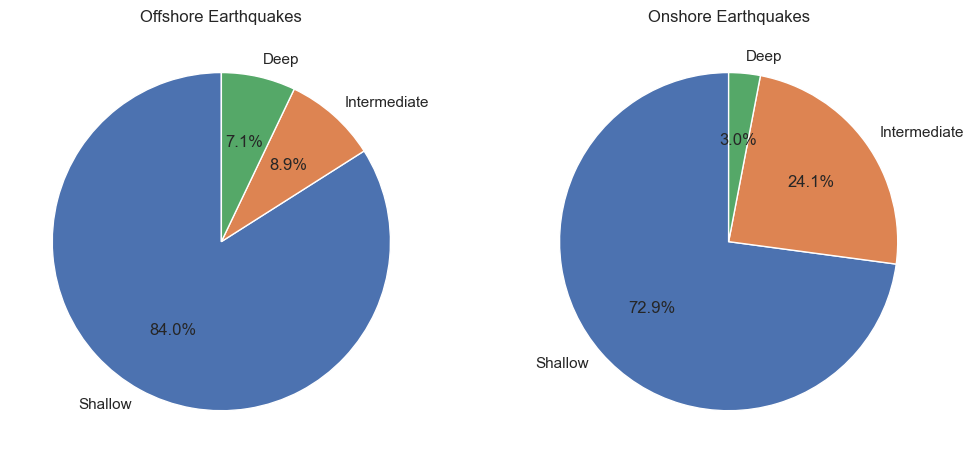

In [324]:

# Grouping by "offshore" and "depthCat" and counting occurrences
df_grouped = df.groupby(["offshore", "depCat"]).size().reset_index(name='count')

# Separating the DataFrame based on the "offshore" column
f1_offshore = df_grouped[df_grouped["offshore"] == True]
f2_onshore = df_grouped[df_grouped["offshore"] == False]

# Creating subplots to display pie charts in one plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Ploting the offshore pie chart
axs[0].pie(f1_offshore['count'], labels=f1_offshore['depCat'], autopct='%1.1f%%', startangle=90)
axs[0].set_title('Offshore Earthquakes')

# Plotting the onshore pie chart
axs[1].pie(f2_onshore['count'], labels=f2_onshore['depCat'], autopct='%1.1f%%', startangle=90)
axs[1].set_title('Onshore Earthquakes')

plt.show()


##### The pie charts reveal some noteworthy insights into the depth of earthquakes that occur offshore and onshore. <br>Although offshore earthquakes have a much higher percentage that occur in the <b>shallow</b> depth category (0-70km) they also have a larger percentage of <b>deep</b> (300-700km) depth earthquakes when compared to onshore earthquakes. <br>Onshore earthquakes have a substantially larger share of <b>intermediate</b> (70-300km) depth earthquakes of 24.1% when compared to the 8.9% of onshore earthquakes.

##### By plotting a Kernel Density Estimation (KDE) function using the seaborn library, we can gain a detailed comparison of the distribution of depths between earthquakes that occur onshore and earthquakes that occur offshore. A Kernel Density Estimate provides a smooth estimate of the underlying distribution of depth values.

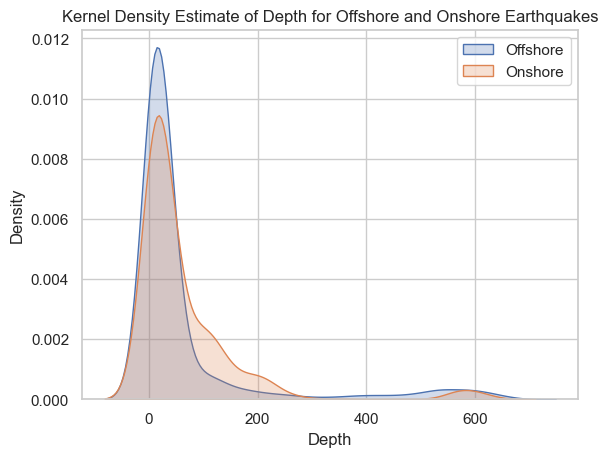

In [325]:
# Ploting KDE for offshore earthquakes
sns.kdeplot(data=df[df['offshore']], x='depth', label='Offshore', fill=True)

# Ploting KDE for onshore earthquakes
sns.kdeplot(data=df[~df['offshore']], x='depth', label='Onshore', fill=True)

# Titling and Labelling
plt.xlabel('Depth')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Depth for Offshore and Onshore Earthquakes')

plt.legend()
plt.show()


##### From the peaks visible in the KDE plot, we can ovserve that there is a higher concentration of <b>offshore</b> earthquakes that occur at the 0-50km depths. <b>Onshore</b> earthquakes have a similar, less concentrated value of depths. However, the positive tail informs us that <b>onshore</b> earthquakes have a higher estimated probability density in the 100km-250km depth range than <b>offshore</b> earthquakes. Interestingly both <b>offshore</b> and <b>onshore</b> earthquakes exhibit a small peak at the 600km depth range.

##### By partitioning the data into the three depth categories we can analyse the magnitude means of each depth category to identify which depth category has the highest magnitude means

In [326]:
df_shallow = df[df["depCat"] == "Shallow"]
df_intermediate = df[df["depCat"] == "Intermediate"]
df_deep = df[df["depCat"] == "Deep"]

print("Shallow data mean")
print(df_shallow["mag"].mean())

print("\nIntermediate data mean")
print(df_intermediate["mag"].mean())

print("\nDeep data mean")
print(df_deep["mag"].mean())

Shallow data mean
5.855166356135214

Intermediate data mean
5.919449541284403

Deep data mean
6.006920415224912


##### From the above analysis, we can see that the <b>Deep</b> has the highest magnitude mean of the three depth categories (6.01 magnitude). Followed closely by <b>Intermediate</b> (5.92 magnitude) and <b>Shallow</b> (5.86 magnitude). This shows us that the depth of the earthquake does not have a significant effect on the magnitude of the earthquake.

##### By using the Geopandas library, we can use the latitude and longitude data to plot each earthquake on a world map. By associating the colouring of the points with their respective depth category. We can visualise the geographical occurance of the depth categories.

C:\Users\chris\AppData\Local\Temp\ipykernel_16432\1995665693.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


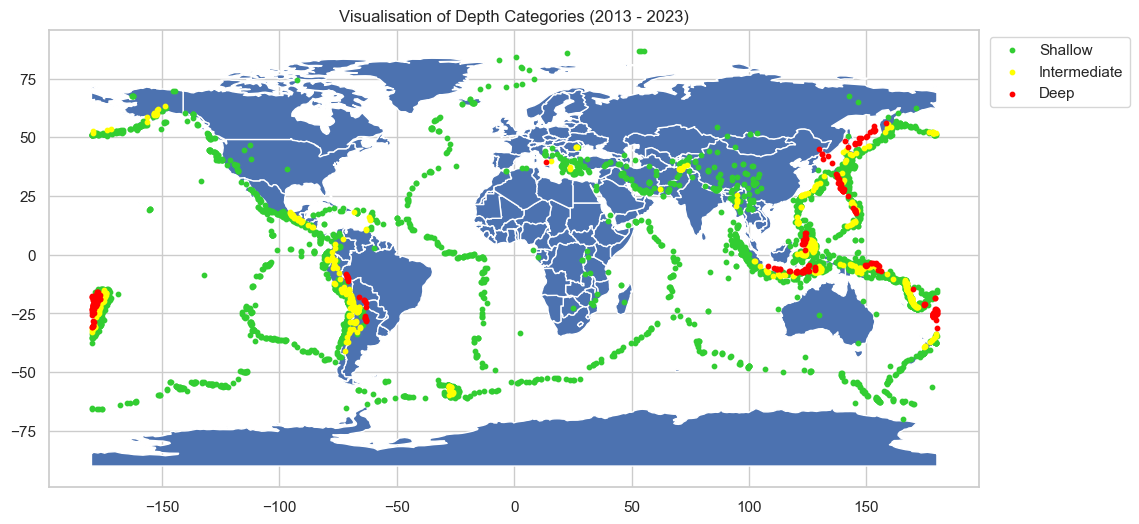

In [327]:
# Creating GeoDataFrames with geometry column
gdf_deep = gpd.GeoDataFrame(df_deep, geometry=gpd.points_from_xy(df_deep.longitude, df_deep.latitude))
gdf_intermediate = gpd.GeoDataFrame(df_intermediate, geometry=gpd.points_from_xy(df_intermediate.longitude, df_intermediate.latitude))
gdf_shallow = gpd.GeoDataFrame(df_shallow, geometry=gpd.points_from_xy(df_shallow.longitude, df_shallow.latitude))

# Plotting a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(12, 10))

# Displaing the points for each depCat category on the world map
gdf_shallow.plot(ax=ax, color='limegreen', markersize=10, label='Shallow')
gdf_intermediate.plot(ax=ax, color='yellow', markersize=10, label='Intermediate')
gdf_deep.plot(ax=ax, color='red', markersize=10, label='Deep')


# Making a legend
ax.legend(bbox_to_anchor=(1.17, 1))
plt.title("Visualisation of Depth Categories (2013 - 2023)")

plt.show()


##### The visualisation of the depth categories of earthquakes illustrate what we learned from the pie charts above. Here we can see that more "Deep" earthquakes occur offshore. We can also see a clustering of onshore "Intermediate" depth events along the west coast of South America. <br>By plotting the coordinate data of each earthquake we can also see a clear outline of the boundaries of the tectonic plates.<br>We can also see a cluster of "<b>Deep</b>" earthquakes in the south of the Pacific Ocean. This map highlights that deep earthquakes occur in particular areas along spceific fault lines. 

### <b>Time</b> analysis

##### We can begin the time analysis by displaying the amount of earthquakes in descending order over the last 10 years

In [328]:
years = df["year"].value_counts()

print(years)

year
2021    561
2018    483
2014    480
2016    470
2013    461
2015    446
2022    446
2019    443
2020    405
2017    396
Name: count, dtype: int64


##### To further analyse these figures, we can use a stacked bar chart to break the total earthquakes that occured each year down into magnitude classes.

<Figure size 1000x600 with 0 Axes>

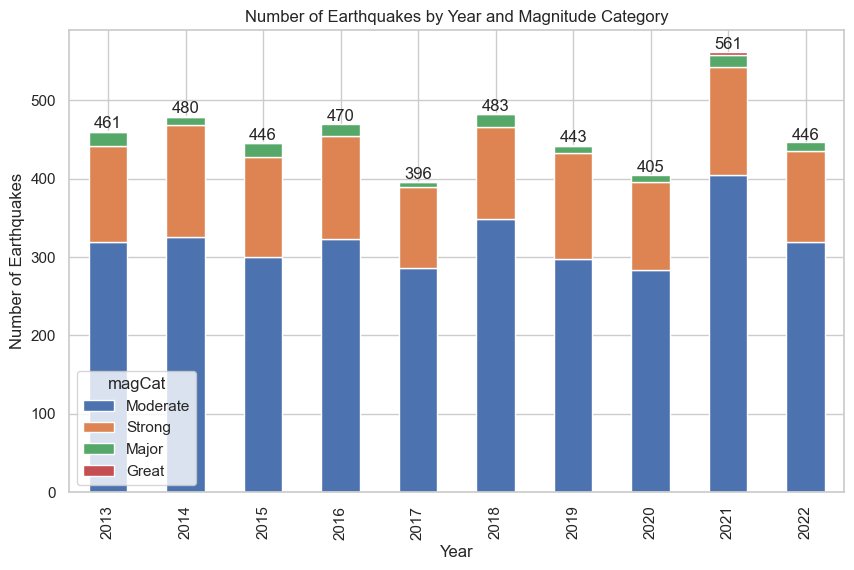

In [329]:
# Pivoting table to display year and magnitude category
pivot_table = df.pivot_table(index='year', columns='magCat', aggfunc='size', fill_value=0)

# Ploting stacked bar chart using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Printing "total" events for each year at the top of each bar
total_earthquakes = pivot_table.sum(axis=1)
for i, total in enumerate(total_earthquakes):
    ax.annotate(f'{total}', (i, total), ha='center', va='bottom')

# Labelling and titling
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.title('Number of Earthquakes by Year and Magnitude Category')
plt.show()


##### 2021 had the most earthquakes (>5.5 magnitude) by a considerable margin. There is a notable difference in the amount of earthquakes from 2021 to 2017, 2021 had 165 more earthquakes than 2017. <br> Because great earthquakes are uncommon, the occurrance of great earthquakes in this stacked bar chart is not easily visible. We can make another bar chart isolating only great earthquakes and view their occurance by year.

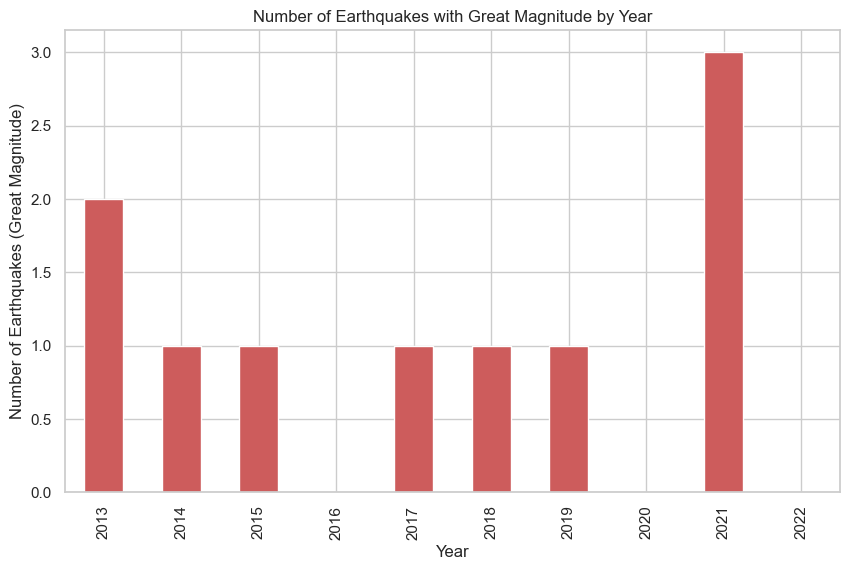

In [330]:
# Selecting only the 'Great' category magtnitude events from our previously made pivot table
great_magnitude_by_year = pivot_table['Great']

# plotting "great" category events
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
great_magnitude_by_year.plot(kind='bar', color='indianred', figsize=(10, 6))

# Labelling and titling
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes (Great Magnitude)')
plt.title('Number of Earthquakes with Great Magnitude by Year')

plt.show()


##### From this bar chart we can see that similarly to the total number of earthquakes, 2021 had the most great category earthquakes with 3 great earthquakes. We can also see that 2016 and 2020 did not have any "great" category earthquakes. <br>By extracting only the "great" category earthquakes in the year 2021 from our DataFrame we can see more details about these earthquakes. 

In [331]:
df_great2021 = df[(df["magCat"]=="Great") & (df["year"]==2021)]
df_great2021.head()

,latitude,longitude,depth,mag,dmin,rms,net,id,place,horizontalError,depthError,offshore,year,month,day,magCat,depCat
2,55.3635,-157.8876,35.00,8.2,NaN,0.95,ak,ak0219neiszm,Alaska Peninsula,NaN,0.0,True,2021,7,29,Great,Shallow
6,-58.3753,-25.2637,22.79,8.1,7.463,0.76,us,us6000f53e,South Sandwich Islands region,8.0,3.6,True,2021,8,12,Great,Shallow
7,-29.7228,-177.2794,28.93,8.1,0.739,0.69,us,us7000dflf,"Kermadec Islands, New Zealand",7.7,3.3,True,2021,3,4,Great,Shallow


##### We can see that the three largest earthquakes of 2021 were <br><b>- 29/07/2021</b> Off the Coast of the Alaskan Peninsula, Magnitude 8.2<br><b>- 12/08/2021</b> South Sandwich Islands Region, Magnitude 8.1<br><b>- 04/03/2021</b> Kermadec Islands New Zealand, Magnitude 8.1<br>All three of the great earthquaks that occurred in 2021 were of the "Shallow" depth category. 

##### By taking the max value of magnitude for 2016 and 2020, we can see what the highest magnitude earthquakes were for those years, and see how close those earthquakes came to being categorised as "great" (magnitude >8.0)

In [332]:
#2016
df_2016 = df[df["year"] == 2016]
max_2016 = df_2016["mag"].idxmax()

print("Highest magnitude earthquake 2016:")
df_2016.loc[[max_2016]]



Highest magnitude earthquake 2016:


,latitude,longitude,depth,mag,dmin,rms,net,id,place,horizontalError,depthError,offshore,year,month,day,magCat,depCat
11,-4.5049,153.5216,94.54,7.9,1.389,0.97,us,us200081v8,"140 km E of Kokopo, Papua New Guinea",7.3,3.8,True,2016,12,17,Major,Intermediate


In [333]:
#2020
df_2020 = df[df["year"] == 2020]
max_2020 = df_2020["mag"].idxmax()

print("Highest magnitude earthquake 2020:")
df_2020.loc[[max_2020]]

Highest magnitude earthquake 2020:


,latitude,longitude,depth,mag,dmin,rms,net,id,place,horizontalError,depthError,offshore,year,month,day,magCat,depCat
19,55.0715,-158.596,28.0,7.8,0.621,0.97,us,us7000asvb,"99 km SSE of Perryville, Alaska",5.4,1.9,True,2020,7,22,Major,Shallow


##### To identify if the intenity of earthquakes is seasonal, we can use a line chart to plot the average magnitude of each month over the last 10 years. We can also partition the data into offshore and onshore to examine the difference in magnitude means between offshore and onshore earthquakes

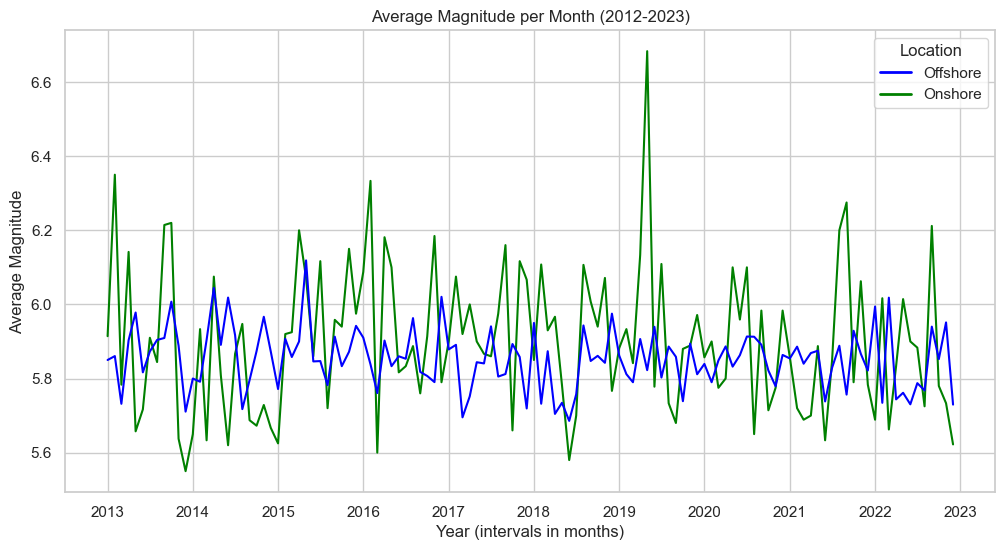

In [334]:
# Re-converting "year" and "month" columns back to datetime format
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')


# Grouping by year_month and calculate the average magnitude for both onshore and offshore earthquakes
average_magnitude_per_month = df.groupby(['year_month', 'offshore'])['mag'].mean().reset_index()

# manually assigning colours for legend, due to "offshore" type boolean creating issue for seaborn legend
colors = {True: 'blue', False: 'green'}

# Ploting the monthly average magnitude data using seaborn with separate lines for onshore and offshore
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='mag', hue='offshore', data=average_magnitude_per_month, palette=colors)
plt.title('Average Magnitude per Month (2012-2023)')
plt.xlabel('Year (intervals in months)')
plt.ylabel('Average Magnitude')

# Creating legend using manually assigned colours
legend_labels = ['Offshore', 'Onshore']
legend_handles = [plt.Line2D([0], [0], color=colors[val], lw=2) for val in [True, False]]
plt.legend(legend_handles, legend_labels, title='Location')

plt.show()


##### From this line graph we can see that there is no clear association between magnitude and time of year. However, this graph does illustrate that onshore earthquakes tend to have a higher monthly average than offshore earthquakes.

### <b>Magnitude Analysis</b>

##### We can begin the analysis of magnitude by summarising the data.

In [335]:
df["mag"].describe()

count    4591.000000
mean        5.872350
std         0.425604
min         5.500000
25%         5.600000
50%         5.700000
75%         6.000000
max         8.300000
Name: mag, dtype: float64

##### The mean magnitude of the earthquakes in the DataFrame is 5.87, a mean this close to the minimum value (5.5) suggests that the spread of magnitude values in the DataFrame is highly concentrated around the lower bound.

##### We can extract the highest magnitude earthquake from the dataset, which according to the above summarisation should have a magnitude of 8.3 <br><br>Highest Magnitude Earthquake

In [336]:
max_mag_event = df["mag"].idxmax()

print("Highest magnitude earthquake:")
df.loc[[max_mag_event]]

Highest magnitude earthquake:


,latitude,longitude,depth,mag,dmin,rms,net,id,place,horizontalError,depthError,offshore,year,month,day,magCat,depCat,year_month
0,-31.5729,-71.6744,22.44,8.3,0.684,1.02,us,us20003k7a,"48 km W of Illapel, Chile",4.7,3.2,True,2015,9,16,Great,Shallow,2015-09-01


##### The highest recorded magnitued of the last 10 calendar years occured off the west coast of Chile on the 16th of September 2015. It was an 8.3 magnitude earthquake with a depth of 22.44km

##### By using the geopandas package once again, we can plot each earthquake on a world map using the coordinate data. We can the colour the point data using the magnitude classes.

C:\Users\chris\AppData\Local\Temp\ipykernel_16432\2314920348.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_mag = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


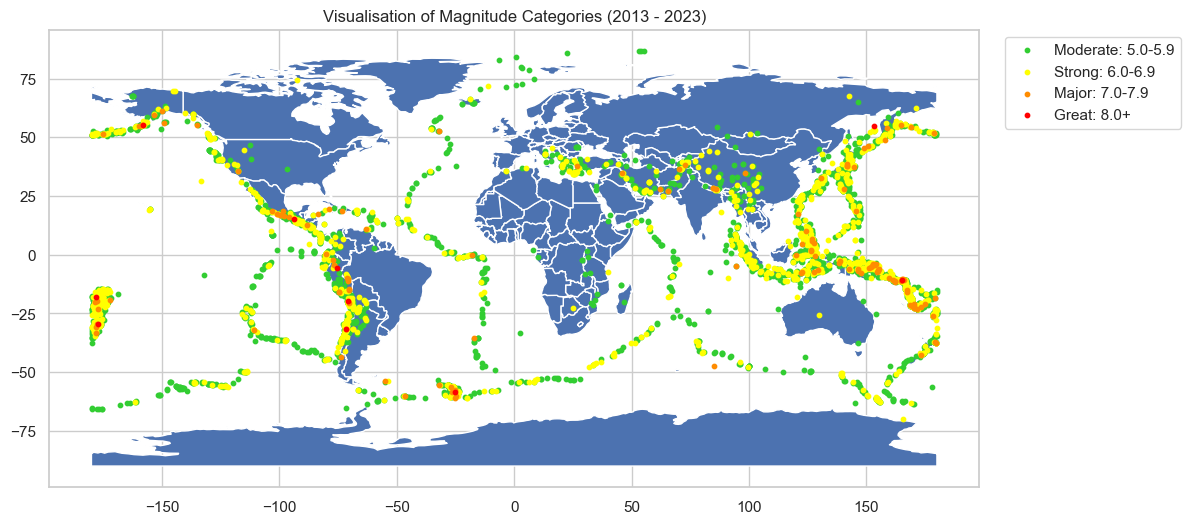

In [337]:

df_great = df[df["magCat"] == "Great"]
df_major = df[df["magCat"] == "Major"]
df_strong = df[df["magCat"] == "Strong"]
df_moderate = df[df["magCat"] == "Moderate"]

# Creating a GeoDateFrame using the geopandas package and the lat and long values
gdf_great = gpd.GeoDataFrame(df_great, geometry=gpd.points_from_xy(df_great.longitude, df_great.latitude))
gdf_major = gpd.GeoDataFrame(df_major, geometry=gpd.points_from_xy(df_major.longitude, df_major.latitude))
gdf_strong = gpd.GeoDataFrame(df_strong, geometry=gpd.points_from_xy(df_strong.longitude, df_strong.latitude))
gdf_moderate = gpd.GeoDataFrame(df_moderate, geometry=gpd.points_from_xy(df_moderate.longitude, df_moderate.latitude))

# Ploting a world map template
world_mag = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world_mag.plot(figsize=(12, 10))

# Plotting magnitude categories on the map template
gdf_moderate.plot(ax=ax, color='limegreen', markersize=10, label='Moderate: 5.0-5.9')
gdf_strong.plot(ax=ax, color='yellow', markersize=10, label='Strong: 6.0-6.9')
gdf_major.plot(ax=ax, color='darkorange', markersize=10, label='Major: 7.0-7.9')
gdf_great.plot(ax=ax, color='red', markersize=10, label='Great: 8.0+')

# Displaing a legend
ax.legend(bbox_to_anchor=(1.02, 1))
plt.title("Visualisation of Magnitude Categories (2013 - 2023)")

plt.show()

##### By using a boxplot, we can visualise the distribution, mean, and spread of magnitudes across the three depth categories and identify a possible correlation between depth and magnitude.

C:\Users\chris\AppData\Local\Temp\ipykernel_16432\149220300.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='depCat', y='mag', data=df, palette='viridis')


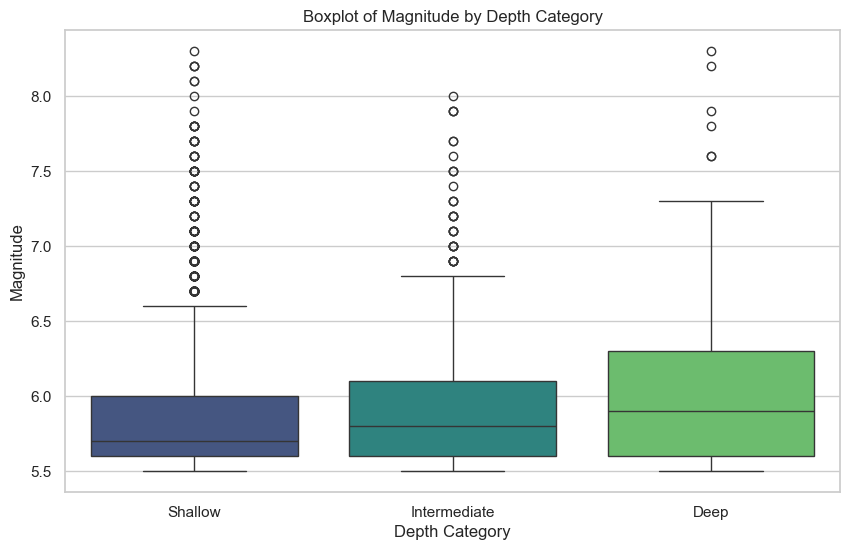

In [338]:
# Making a seaborn boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='depCat', y='mag', data=df, palette='viridis')

# labelling and titling
plt.xlabel('Depth Category')
plt.ylabel('Magnitude')
plt.title('Boxplot of Magnitude by Depth Category')

plt.show()


##### From the boxplot we can see that the "<b>Shallow</b>" depth category has the least variation, but also has a substantial amount of outliers. This, indicates a high concentration of earthquakes in the <b>Shallow</b> depth category with a recorded magnitude of 5.5 - 6.0. The positioning of the median in the box illustrates that the distribution of magnitudes is positively skewed for <b>Shallow</b> earthquakes. This further emphasises the concentration of magnitudes in the <b>shallow</b> depth category closer to 5.5 than to 6.0.<br> The large amount of outliers, particularly in the <b>Shallow</b> depth category represents earthquakes that significantly deviate from the expected distribution. <br>The boxes for the "<b>Intermediate</b>" and "<b>Deep</b>" have a taller set of upper whiskers. This indicates a greater variation of values within the dataset. In comparison, the shorter upper whiskers of the "<b>Shallow</b>" category in conjunction with the prevalence of outliers indicates that the majority of the data is concentrated within a narrow range, however, outliers exist above this range. <br>In the context of this data, this tells us that although the majority of earthquakes that occur between 0-70km underground have a magnitude of lower than 6.0, shallow earthquakes do have the potential to have magnitudes of over 8.0. This hints towards depth and magnitude having very little correlation

##### To further anaylse the correlation of the depth and magnitude of an earthquake we can calculate the correlation coefficient

In [339]:
correlation = df['depth'].corr(df['mag'])
print(f'Correlation coefficient: {correlation}')


Correlation coefficient: 0.10586012813499454


##### The correlation coefficient of 0.106 indicates a very weak positive correlation between depth and magnitude. This suggests that an increase in depth is not strongly associated with an increase in magnitude.

##### To examine the distribution of magnitude categories in each depth category we can create pie charts for each depth category.

C:\Users\chris\AppData\Local\Temp\ipykernel_16432\1370167815.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(["depCat", "magCat"]).size().reset_index(name='count')


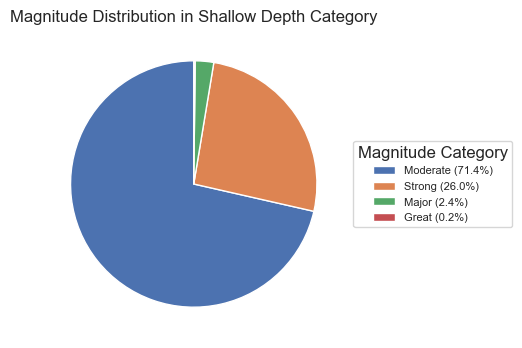

In [340]:
# Grouping by "depCat" and "magCat"
df_grouped = df.groupby(["depCat", "magCat"]).size().reset_index(name='count')

# Filtering for the "Shallow" depth category
shallow_df = df_grouped[df_grouped["depCat"] == "Shallow"]

# Plotting the pie chart for the "Shallow" depth category
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(shallow_df['count'], autopct='', startangle=90, textprops=dict(color="black"))

# labelling and titling
legend_labels = [f"{cat} ({count:.1%})" for cat, count in zip(shallow_df['magCat'], shallow_df['count'] / shallow_df['count'].sum())]
ax.legend(wedges, legend_labels, title="Magnitude Category", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=8)
ax.set_title('Magnitude Distribution in Shallow Depth Category')

plt.show()


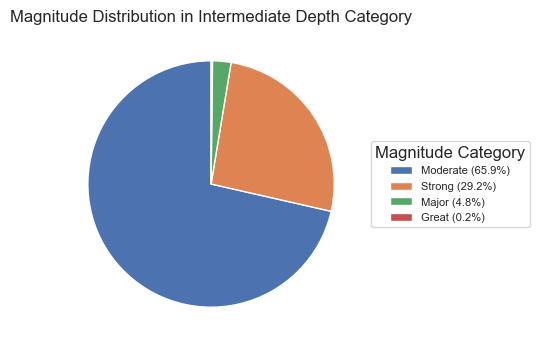

In [341]:
# Filtering for the "Intermediate" depth category
intermediate_df = df_grouped[df_grouped["depCat"] == "Intermediate"]

# Plotting the pie chart for the "Intermediate" depth category
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(shallow_df['count'], autopct='', startangle=90, textprops=dict(color="black"))

# labelling and titling
legend_labels = [f"{cat} ({count:.1%})" for cat, count in zip(intermediate_df['magCat'], intermediate_df['count'] / intermediate_df['count'].sum())]
ax.legend(wedges, legend_labels, title="Magnitude Category", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=8)
ax.set_title('Magnitude Distribution in Intermediate Depth Category')

plt.show()

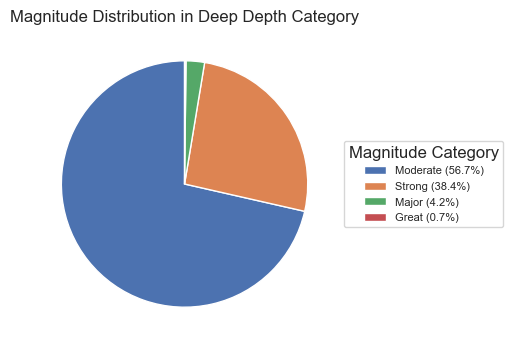

In [342]:
# Filtering for the "Deep" depth category
deep_df = df_grouped[df_grouped["depCat"] == "Deep"]

# Plotting the pie chart for the "Deep" depth category
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(shallow_df['count'], autopct='', startangle=90, textprops=dict(color="black"))

# titling and labelling
legend_labels = [f"{cat} ({count:.1%})" for cat, count in zip(deep_df['magCat'], deep_df['count'] / deep_df['count'].sum())]
ax.legend(wedges, legend_labels, title="Magnitude Category", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=8)
ax.set_title('Magnitude Distribution in Deep Depth Category')

plt.show()

##### The pie charts tell us that of the three depth categories, the <b>deep</b> depth category has the highest percentage of great earthquakes (0.7%), and the highest percentage of non moderate earthquakes (43.4%). However, <b>intermediate</b> depth earthquakes have the highest percentage of major earthquakes. <b>Shallow</b> level earthquakes have the least percentage of strong, major, and great magnitude earthquakes, this reinforced what we saw in the boxplots. In the boxplots we observed a high concentration of 5.5-6.0 magnitude earthquakes in the <b>shallow</b> depth category.

##### We can once again use a Kernel Density Estimation (KDE) plot to view the distribution of magnitudes for offshore and onshore earthquakes

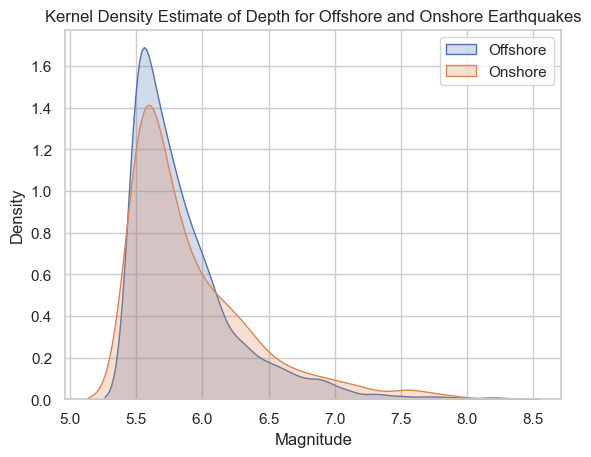

In [343]:

# Ploting KDE for offshore and onshore earthquakes
sns.kdeplot(data=df[df['offshore']], x='mag', label='Offshore', fill=True)
sns.kdeplot(data=df[~df['offshore']], x='mag', label='Onshore', fill=True)

# labelling and titling
plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Depth for Offshore and Onshore Earthquakes')
plt.legend()

plt.show()

##### The pattern seen above is similar in nature to the previous KDE plot which visualised the distribution of depth. We observe a high concentraction of <b>offshore</b> earthquakes around a recorded magnitude of 5.5. <b>Onshore</b> earthquakes have a similar concentration, however, there is also a larger spread which indicates that the magnitude values for onshore earthquakes have a larger variation, and are less concentrated.

### <b>Task 3</b>

##### <b>Challenges Faced</b><br>The primary issues faced in the retrieval of earthquake data from the USGS.gov api relate to the format of the API request. I initially attempted to send an API request in xml format. However, although the request did not return an error, when printing the returned "earthquake_data.xml" it was null. <br>I then attempted to use a json format api request. The USGS website does not list "json" as an accepted request and instead lists "geojson" due to the geographic data structure to support mapping. USGS does state that a work around to this is to use the mime-type "application/json" on the request url, however this also posed issues in the retrieval of data. After appending the request url with the "application/json" a status 400 code was returned which indicates an issue with the request. <br>After tweeking the API request, using "format: csv" returned the desired dataset of earthquakes over 5.5 magnitude for the last 10 years. This could then be transformed into a pandas DataFrame before the preprocessing and cleaning stage

##### <b>Key Insights Gained</b> <br>The key insights gained from my analysis of my data frame relate the use of the geopandas package to plot the earthquakes on a world map. From this anaylsis I learned that deep earthquakes are clustered along particular fault lines and are concentrated in specific locations rather than being spontanteous events that can happen along any particular fault line. I previously had also though that the deeper an earthquake occurs underground, the greater the magnitude of the earhtquake would be. However after running various analysis methods of the two variables, I learned that there was only a week correlation between the two. <br>It was also interesting to learn that "great" magnitude earthquakes are rare, with only 10 happening in the last 10 calendar years. By normalising the data using a KDE plot I was able to gain a coherent insight into the distribution of magnitude and depth between offshore and onshore earthquakes. I also saw how the severity of earthquakes is not seasonal. <br>Finally, I observed that although the lower bound for my request was a magnitude of 5.5, there was a very significant concentration of values at the 5.5 - 6.0 magnitude.

##### <b>Possible Further Analysis</b> <br>For further analysis it would be appealing to analyse errors in the recording of the depth of earthquakes. For example, to analyse whether deeper earthquakes have a higher measure of error. If coordinate data is available for the measurement stations that record each earthquake, it could be possible to investigate how the distance from the earthquake to the nearest station affects the measurement errors. This could then be used to highlight areas that measurement stations need to be built. The inclusion of other numerical data could provide more in-depth analysis. Numerical data such as the cost of damage associated with an earthquake, how long the earthquake/tremors lasted, number of aftershocks, etc., could provide further comparative analysis of earthquakes. When working with the two numerical columns of depth and magnitude I felt limited in my analysis at points, however by creating columns such as offshore/onshore and creating categorical columns for depth and magnitude it allowed me to continue with different forms of analysis.